# sourmash, mash and CMash comparison

(the smol gather experiment)

This experiment compares sourmash scaled signatures, CMash and mash screen for containment queries.
Experiments were run for ksizes of `21, 31, 51` (except for mash, which only supports `k<=32`).
For mash there is also data for both `num=1000` and `num=100000`.
You can change the numbers below and rerun the notebook to compare results.

There is also an exact version to use as baseline/truth set. It is implemented in Rust, using the `HashSet` in the standard library.

In [1]:
ksize = 21
num = 1000

In [2]:
import numpy as np
import pandas as pd
from IPython.display import Image

## Loading data

Loading four dataframes, one for each method plus the exact counts. Harmonize filenames so we can merge the dataframes further down in the analysis.

### sourmash

`sourmash_g` uses the `f_match` column (how much of the found genome is contained in the metagenome) for the `sourmash gather` output:

In [3]:
sourmash_g = pd.read_table(f"../outputs/scaled_1000/SRR606249-k{ksize}.csv",
                         sep=",",
                         usecols=["f_match", "filename"])
sourmash_g.columns = ("sourmash_g", "filename")
sourmash_g["filename"] = sourmash_g["filename"].str.replace(r".*/(?P<id>\d+).sig", lambda m: m.group("id") + ".fa")
sourmash_g.set_index("filename", inplace=True)

Since the `f_match` column doesn't take into account hashes shared with other matches, it underrepresents containment to the original datasets. `sourmash_c` uses `sourmash search --containment` to report containment including shared hashes.

In [4]:
sourmash_c = pd.read_table(f"../outputs/scaled_1000/containments_SRR606249-k{ksize}.csv",
                         sep=",",
                         usecols=["containment", "filename"])
sourmash_c.columns = ("sourmash_c", "filename")
sourmash_c.set_index("filename", inplace=True)

### CMash

CMash outputs the filename and one column per k-size with the containment to each match.
I built an index with `k=51` and queried with ranges `21-51-10` (ksizes `21,31,41,51`):

In [5]:
cmash = pd.read_table("../outputs/cmash/SRR606249.csv",
                      sep=",")
cmash.columns = ["filename"] + [c for c in cmash.columns[1:]]
cmash.set_index("filename", inplace=True)
columns = [c for c in cmash.columns if str(ksize) not in c]
cmash.drop(columns=columns, inplace=True)
cmash.columns = ["cmash "] + cmash.columns

### mash

`mash screen` outputs containment in the first column, and again harmonizing filename to be able to join dataframes later.

Since `mash sketch` has a cutoff parameter `-m` that can be used to discard k-mers below the cutoff during sketch construction, I tried using `-m 1` and `-m 2` to see if there are differences:

In [6]:
if ksize <= 32:  # mash doesn't support k>32
    mash_m2 = pd.read_table(f"../outputs/mash_screen/SRR606249-k{ksize}-s{num}-m2.tsv",
                                header=None,
                                names=("mash_m2", "hashes", "median abundance", "p-value", "filename", "description"),
                                usecols=["filename", "mash_m2"])
    mash_m2["filename"] = mash_m2["filename"].str.replace(".*/", "")
    mash_m2.set_index("filename", inplace=True)

In [7]:
if ksize <= 32:  # mash doesn't support k>32
    mash_m1 = pd.read_table(f"../outputs/mash_screen/SRR606249-k{ksize}-s{num}-m1.tsv",
                                header=None,
                                names=("mash_m1", "hashes", "median abundance", "p-value", "filename", "description"),
                                usecols=["filename", "mash_m1"])
    mash_m1["filename"] = mash_m1["filename"].str.replace(".*/", "")
    mash_m1.set_index("filename", inplace=True)

If we plot a histogram of the differences we see that most results agree (on the containment measure), so using `-m 1` from now on (which also matches the default sourmash and CMash behavior).

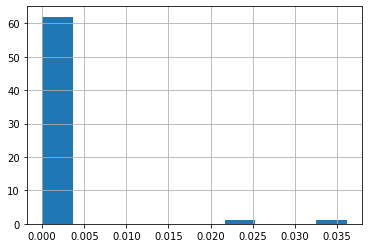

In [8]:
with pd.option_context('display.max_rows', None):
    display((mash_m1["mash_m1"] - mash_m2["mash_m2"]).abs().sort_values().hist())

### Exact

The exact code uses the Rust `HashSet` from the standard library to keep all k-mers in the query metagenome, as well as each of the reference genomes, storing it on disk for later comparisons. It uses [needletail]() for FASTA/Q parsing, keep the canonical k-mer (smaller between k-mer and reverse complement), and its sequence normalization method (described in the [docs](https://docs.rs/needletail/0.3.2/needletail/sequence/fn.normalize.html), copied here for easier reference):
```
Transform a nucleic acid sequence into its "normalized" form.

The normalized form is:

    only AGCTN and possibly - (for gaps)
    strip out any whitespace or line endings
    lowercase versions of these are uppercased
    U is converted to T (make everything a DNA sequence)
    some other punctuation is converted to gaps
    IUPAC bases may be converted to N's depending on the parameter passed in
    everything else is considered a N
```

TODO: evaluate how this is different from how each tool processes non-ACGT bases:
- sourmash converts all bases to uppercase, skips k-mers with N (or any non-ACGT bases), keep canonical
- cmash: same as sourmash
  * ref https://github.com/dkoslicki/CMash/blob/db7da08cd897edabfccbbe7bd252572799737c5e/CMash/MinHash.py#L166
- mash: uppercase (unless preserveCase is set), skip bad k-mers (not in alphabet), keep canonical (unless ?option? is set)
  * ref https://github.com/marbl/Mash/blob/a1afacd0ef3f503ba0133a1b8bb57b79b795dfe7/src/mash/Sketch.cpp#L509

In [9]:
exact = pd.read_table(f"../outputs/exact/SRR606249-k{ksize}.csv",
                       sep=",",
                       header=None,
                       names=("filename", "exact", "intersection", "|A|"),
                       usecols=("filename", "exact"))
exact["filename"] = exact["filename"].str.replace(r".*/(?P<id>\d+)-k\d+.set", lambda m: m.group("id") + ".fa")
exact.set_index("filename", inplace=True)

## Containment checks

Merging the three dataframes, and since the `containment` for each method is in a column with the method name, it is easy to get the proper labels for plotting later.

In [10]:
#all_methods = pd.concat((exact, cmash, mash_m1, mash_m2, sourmash_c, sourmash_g), axis=1)
if ksize > 31:  # mash doesn't support k>32
    all_methods = pd.concat((exact, sourmash_c, sourmash_g, cmash), axis=1)
else:
    all_methods = pd.concat((exact, sourmash_c, sourmash_g, cmash, mash_m1, mash_m2), axis=1)

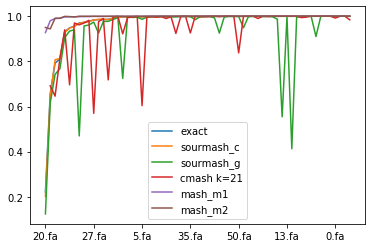

In [11]:
all_methods.sort_values(by="exact").plot()

mash containment is always above .95, but it is hard to visualize what is happening in this graph. Let's try to use a table, and filter out results where they agree (where "agree" is at most an 1% difference in containment):

In [12]:
def highlight_diff_from_exact(s):
    diff = np.abs(s - s['exact'])
    colorized = []
    for v in diff:
        if v < .01: colorized.append('background-color: white')
        elif v < .05: colorized.append('background-color: yellow')
        elif v < .1: colorized.append('background-color: orange')
        else: colorized.append('background-color: red')
    return colorized

with pd.option_context('display.max_rows', None, 'show_dimensions', True):
    df = all_methods.sort_values(by="sourmash_c")
    df = df[df.apply(lambda x: any(np.abs(x - x['exact']) > .05), axis=1)]
    display(df.style.apply(highlight_diff_from_exact, axis=1))

,exact,sourmash_c,sourmash_g,cmash k=21,mash_m1,mash_m2
20.fa,0.221234,0.201496,0.124128,nan,0.927528,0.950058
19.fa,0.657820,0.646635,0.615669,0.692000,0.980124,0.943980
55.fa,0.792145,0.807190,0.742596,0.646000,0.989899,0.991280
17.fa,0.811081,0.812327,0.767617,0.814000,0.990767,0.991280
7.fa,0.931290,0.927789,0.905975,0.940000,0.996855,0.999425
6.fa,0.948457,0.947447,0.934101,0.696000,0.997610,0.998502
63.fa,0.970173,0.968531,0.469645,0.962000,0.998206,1.000000
27.fa,0.983803,0.983803,0.974210,0.570000,0.999425,0.999952
47.fa,0.986294,0.984549,0.977400,0.718000,0.999329,1.000000
46.fa,0.985066,0.986071,0.925127,0.976000,0.999329,0.999761


## Similarity and Containment matrices

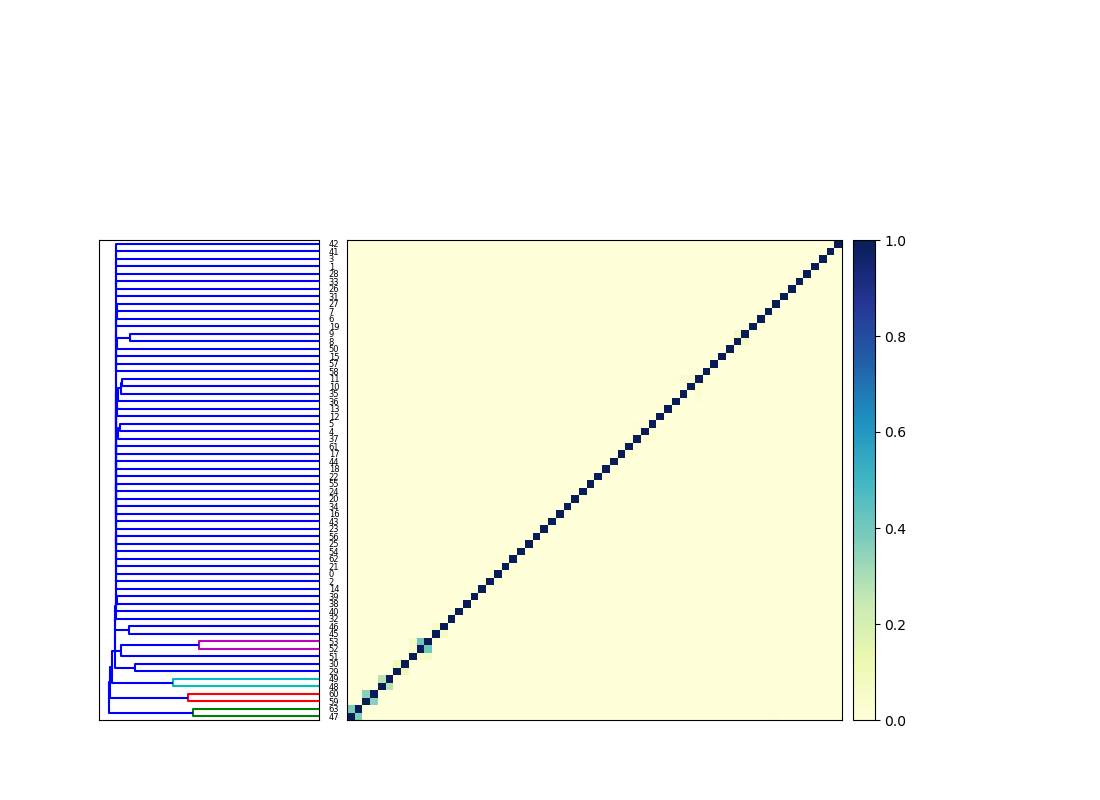

In [13]:
Image(f"../outputs/scaled_1000/similarity-k{ksize}.matrix.png")

## Median abundance (sourmash and mash)

mash also calculates abundance for each hash, so we can compare the median abundance reported by both mash and sourmash.

In [14]:
mash_screen = pd.read_table(f"../outputs/mash_screen/SRR606249-k{ksize}-s{num}-m1.tsv",
                            header=None,
                            names=("mash", "hashes", "median abundance mash", "p-value", "filename", "description"),
                           usecols=("mash", "median abundance mash", "filename"))
mash_screen["filename"] = mash_screen["filename"].str.replace(".*/", "")
mash_screen.set_index("filename", inplace=True)

In [15]:
sourmash = pd.read_table(f"../outputs/scaled_1000/SRR606249-k{ksize}.csv",
                         sep=",",
                         usecols=["f_match", "median_abund", "filename"]
                        )
sourmash.columns = ("sourmash", "median abundance sourmash", "filename")
sourmash["filename"] = sourmash["filename"].str.replace(r".*/(?P<id>\d+).sig", lambda m: m.group("id") + ".fa")
sourmash.set_index("filename", inplace=True)

Keeping only result where the difference in median abundance is at least 1. Also highlighting differences:
 - <span style="color: RGBA(171, 145, 68, 1)">median abundance difference > 10</span>
 - <span style="color: darkred">median abundance difference > 30</span>
 - large containment differences (>0.05): gradient background

In [16]:
def highlight_diff(s):
    mdiff = np.abs(s["median abundance mash"] - s["median abundance sourmash"])
    cdiff = np.abs(s["mash"] - s["sourmash"])

    gradient_bg = 'background: repeating-linear-gradient(45deg, rgba(0, 0, 0, 0.2), rgba(0, 0, 0, 0.2) 10px, rgba(0, 0, 0, 0.3) 10px, rgba(0, 0, 0, 0.3) 20px);'
    bg = ''
    if cdiff >= 0.05: 
        bg = gradient_bg
    
    if mdiff == 1: color = 'background-color: white'
    elif mdiff < 10: color = 'background-color: yellow'
    else: color = 'background-color: red; color:white'
    
    return [bg + color] * 4

abundances = pd.concat((mash_screen, sourmash), axis=1)
with pd.option_context('display.max_rows', None, 'show_dimensions', True):
    diff = abundances["median abundance mash"] - abundances["median abundance sourmash"]
    display(abundances[diff.abs() >= 1].style.apply(highlight_diff, axis=1))

,mash,median abundance mash,sourmash,median abundance sourmash
0.fa,1.000000,32,0.999520,27.000000
1.fa,1.000000,29,0.998647,26.000000
2.fa,1.000000,14,1.000000,12.000000
3.fa,0.999952,49,0.998133,42.000000
4.fa,0.999952,9,0.997446,8.000000
5.fa,0.999809,7,0.986600,6.000000
6.fa,0.997610,6,0.934101,5.000000
7.fa,0.996855,4,0.905975,3.000000
8.fa,0.999952,19,0.948924,16.000000
9.fa,1.000000,14,0.997486,12.000000
